In [ ]:
import matplotlib.pyplot as plt
import numpy as np            
import pandas as pd        
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet169
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_sample_weight

# Đường dẫn thư mục train và test
train_path = r'.\train'
test_path = r'.\test'
val_path = r'.\val'

batch_size = 32 
img_height = 224
img_width = 224


In [2]:
# Data augmentation for training
image_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)

# Data augmentation for testing/validation
test_data_gen = ImageDataGenerator(rescale=1./255)

In [3]:
# Training data generator
train_generator = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)

# Testing data generator
test = test_data_gen.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='rgb', 
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# Validation data generator
validation_generator = image_gen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb'
)


Found 1943 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [4]:
print(train_generator.class_indices)

{'1_Normal': 0, '2_Disease': 1}


In [5]:
# Load the DenseNet169 model
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
densenet_model = Model(inputs=base_model.input, outputs=output)

# Fine-tune more layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Compile the model
densenet_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
early = EarlyStopping(monitor="val_loss", mode="min", patience=8, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [early, learning_rate_reduction, lr_scheduler]

# Compute class weights
unique_classes = np.unique(train_generator.classes)
weights = compute_sample_weight(class_weight='balanced', y=train_generator.classes)
cw = dict(zip(unique_classes, weights))
print(cw)

# Train the model
history = densenet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    class_weight=cw,
    callbacks=callbacks_list
)



{0: 1.763157894736842, 1: 1.763157894736842}
Epoch 1/20
61/61 [==============================] - 196s 3s/step - loss: 1.0810 - accuracy: 0.6912 - val_loss: 0.5378 - val_accuracy: 0.7384 - lr: 1.0000e-04
Epoch 2/20
61/61 [==============================] - 242s 4s/step - loss: 0.9660 - accuracy: 0.7355 - val_loss: 0.5014 - val_accuracy: 0.7706 - lr: 1.0000e-04
Epoch 3/20
61/61 [==============================] - 207s 3s/step - loss: 0.8694 - accuracy: 0.7720 - val_loss: 0.4958 - val_accuracy: 0.7646 - lr: 1.0000e-04
Epoch 4/20
61/61 [==============================] - 210s 3s/step - loss: 0.8632 - accuracy: 0.7699 - val_loss: 0.4903 - val_accuracy: 0.7666 - lr: 1.0000e-04
Epoch 5/20
61/61 [==============================] - 166s 3s/step - loss: 0.8334 - accuracy: 0.7730 - val_loss: 0.5203 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 6/20
61/61 [==============================] - 127s 2s/step - loss: 0.7695 - accuracy: 0.7988 - val_loss: 0.4710 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 7

In [6]:
densenet_model.save('DenseNet169_model.h5')

c:\Users\admin\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [7]:
# Evaluate the model
test_loss, test_acc = densenet_model.evaluate(test)
print('The testing accuracy is:', test_acc * 100, '%')

# Predict the labels for the test data
y_pred = densenet_model.predict(test)
y_pred = np.round(y_pred).astype(int)

# Get the true labels
y_true = test.classes

# Compute metrics
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(y_true, y_pred, target_names=['Normal', 'Disease'])
print('Classification Report:')
print(class_report)

tn, fp, fn, tp = conf_matrix.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
recall = sensitivity
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Sensitivity: {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'F1-Score: {f1_score:.2f}')


20/20 [==============================] - 27s 1s/step - loss: 0.3139 - accuracy: 0.8756
The testing accuracy is: 87.56137490272522 %
20/20 [==============================] - 26s 1s/step
Confusion Matrix:
[[159  38]
 [ 38 376]]
Classification Report:
              precision    recall  f1-score   support

      Normal       0.81      0.81      0.81       197
     Disease       0.91      0.91      0.91       414

    accuracy                           0.88       611
   macro avg       0.86      0.86      0.86       611
weighted avg       0.88      0.88      0.88       611

Sensitivity: 90.82%
Specificity: 80.71%
F1-Score: 0.91


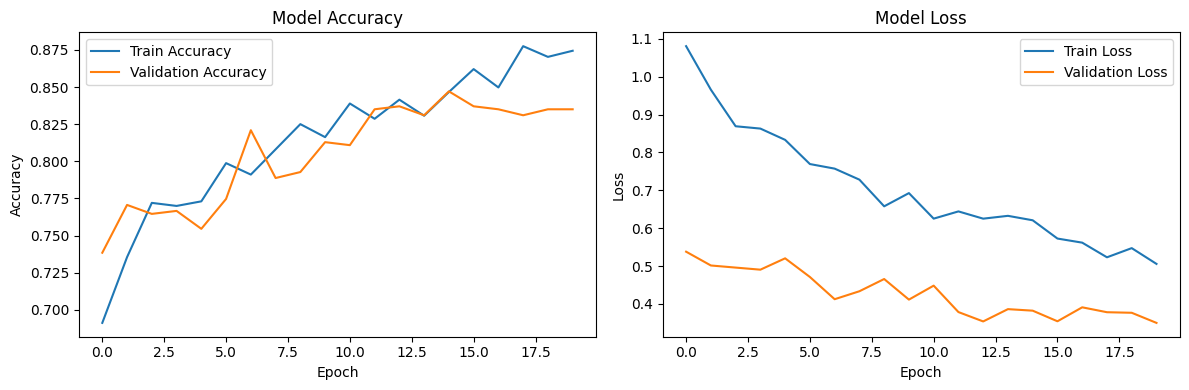

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()